In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

In [2]:
base_str = 'z2r50205t_c'
suffix_str = 'f.fits'
fnames = [base_str + str(i) + suffix_str for i in range(0, 6)]
hdu_list = [fits.open(fname) for fname in fnames]
all_waves = [hdu_list[0][0].data[i, :] for i in [0, 4, 8, 12]]
all_exposure_means = [np.mean(hdu_list[1][0].data[i:i+4, :],
                              axis=0)
                      for i in [0, 4, 8, 12]]
all_exposure_sigmas = [np.sqrt((np.mean((hdu_list[2][0].data[i:i+4,
                                                             :])**2.0,
                                        axis=0))/4.0)
                      for i in [0, 4, 8, 12]]

In [3]:
def cross_correlate(f, g):
    return np.array([np.sum(f*np.roll(g, -(n)))
                     for n in range(0, len(f))])

corr_1 = np.argmax(cross_correlate(all_exposure_means[0],
                                   all_exposure_means[1]))
corr_2 = np.argmax(cross_correlate(all_exposure_means[0],
                                   all_exposure_means[2]))
corr_3 = np.argmax(cross_correlate(all_exposure_means[0],
                                   all_exposure_means[3]))

all_waves[1] = np.roll(all_waves[1], -(corr_1))
all_waves[2] = np.roll(all_waves[2], -(corr_2))
all_waves[3] = np.roll(all_waves[3], -(corr_3))

all_exposure_means[1] = np.roll(all_exposure_means[1], -(corr_1))
all_exposure_means[2] = np.roll(all_exposure_means[2], -(corr_2))
all_exposure_means[3] = np.roll(all_exposure_means[3], -(corr_3))

all_exposure_sigmas[1] = np.roll(all_exposure_sigmas[1], -(corr_1))
all_exposure_sigmas[2] = np.roll(all_exposure_sigmas[2], -(corr_2))
all_exposure_sigmas[3] = np.roll(all_exposure_sigmas[3], -(corr_3))

wave = all_waves[0]
flux = np.mean(np.array(all_exposure_means), axis=0)
variances = np.mean(np.array(all_exposure_sigmas)**2.0, axis=0)/4.
sigmas = np.sqrt(variances)

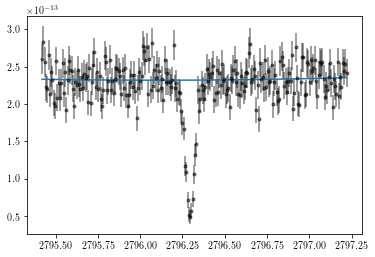

SNR in Continuum =  2.19322e-14
SNR in Line =  11.5792
Poisson-predicted SNR:  2.01618e-14


In [35]:
low1=400
high1=640
wave_1 = wave[low1:high1]
flux_1 = flux[low1:high1]
sigma_1 = sigmas[low1:high1]
cut_index = np.arange(95, 125)
fit_1 = np.polyfit(np.delete(wave_1, cut_index),
                   np.delete(flux_1, cut_index), 2)

plt.errorbar(wave_1, flux_1, yerr=sigma_1,
             alpha=0.5, fmt='.k')
plt.plot(wave_1, np.polyval(fit_1, wave_1))
plt.show()

signal_continuum = np.var(np.delete(flux_1, cut_index))
noise_continuum = np.mean(np.delete(sigma_1, cut_index))
noise_line = np.mean(sigma_1[cut_index])
signal_line = np.mean(np.delete(flux_1, cut_index)) - np.min(flux_1)

print('SNR in Continuum = ',
      signal_continuum/noise_continuum)
print('SNR in Line = ',
      signal_line/noise_line)
print('Poisson-predicted SNR: ', np.sqrt(signal_continuum))

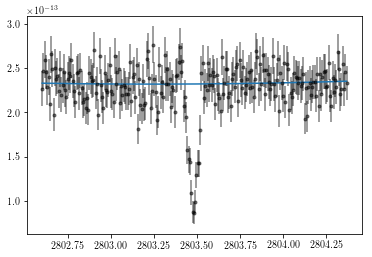

SNR in Continuum =  1.59881e-14
SNR in Line =  8.40444
Poisson-predicted SNR:  1.74424e-14


In [36]:
low2=1360
high2=1600
wave_2 = wave[low2:high2]
flux_2 = flux[low2:high2]
sigma_2 = sigmas[low2:high2]

cut_index = np.arange(95, 125)
fit_2 = np.polyfit(np.delete(wave_2, cut_index),
                   np.delete(flux_2, cut_index), 2)
plt.errorbar(wave_2, flux_2, yerr=sigma_2,
             alpha=0.5, fmt='.k')
plt.plot(wave_2, np.polyval(fit_2, wave_2))
plt.show()

signal_continuum = np.var(np.delete(flux_2, cut_index))
noise_continuum = np.mean(np.delete(sigma_2, cut_index))
noise_line = np.mean(sigma_2[cut_index])
signal_line = np.mean(np.delete(flux_2, cut_index)) - np.min(flux_2)

print('SNR in Continuum = ',
      signal_continuum/noise_continuum)
print('SNR in Line = ',
      signal_line/noise_line)
print('Poisson-predicted SNR: ', np.sqrt(signal_continuum))

In [6]:
normflux_1 = flux_1/np.polyval(fit_1, wave_1)
normsigma_1 = sigma_1/np.polyval(fit_1, wave_1)

normflux_2 = flux_2/np.polyval(fit_2, wave_2)
normsigma_2 = sigma_2/np.polyval(fit_2, wave_2)

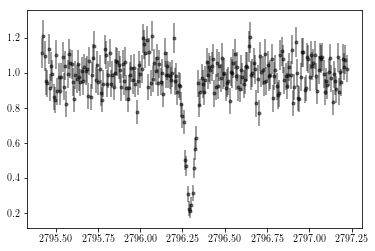

In [7]:
plt.errorbar(wave_1, normflux_1, yerr=normsigma_1,
             alpha=0.5, fmt='.k')
plt.show()

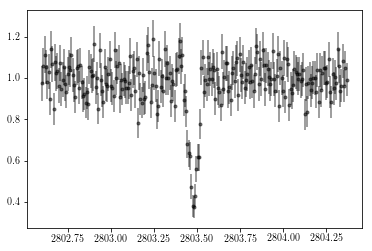

In [9]:
plt.errorbar(wave_2, normflux_2, yerr=normsigma_2,
             alpha=0.5, fmt='.k')
plt.show()